# ML модель 
#### Модель определения болезни по имеющимся симптомам

## Загрузка и маппинг датасета

In [900]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [901]:
data = pd.read_csv('..//data//raw//Disease_symptom_and_patient_profile_dataset.csv')

data = data.astype({
    "Disease": "string",
    "Fever": "string",
    "Cough": "string",
    "Fatigue": "string",
    "Difficulty Breathing": "string",
    "Age": "int64",
    "Gender": "string",
    "Blood Pressure": "string",
    "Cholesterol Level": "string",
    "Outcome Variable": "string"
})

# Gender (Male - 1; Female - 0)
data['Gender'] = data['Gender'].map({'Male':'1', 'Female':'0'}).astype('int64')

# Symptoms (Yes - 1; No - 0)
data['Fever'] = data['Fever'].map({'Yes':'1', 'No':'0'}).astype('int64')
data['Cough'] = data['Cough'].map({'Yes':'1', 'No':'0'}).astype('int64')
data['Fatigue'] = data['Fatigue'].map({'Yes':'1', 'No':'0'}).astype('int64')
data['Difficulty Breathing'] = data['Difficulty Breathing'].map({'Yes':'1', 'No':'0'}).astype('int64')

# Symptoms (High - 2; Normal - 1; Low - 0)
data['Blood Pressure'] = data['Blood Pressure'].map({'High':'2', 'Normal':'1', 'Low':'0'}).astype('int64')
data['Cholesterol Level'] = data['Cholesterol Level'].map({'High':'2', 'Normal':'1', 'Low':'0'}).astype('int64')

# Symptoms (Positive - 1; Negative - 0)
data['Outcome Variable'] = data['Outcome Variable'].map({'Positive':'1', 'Negative':'0'}).astype('int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Disease               349 non-null    string
 1   Fever                 349 non-null    int64 
 2   Cough                 349 non-null    int64 
 3   Fatigue               349 non-null    int64 
 4   Difficulty Breathing  349 non-null    int64 
 5   Age                   349 non-null    int64 
 6   Gender                349 non-null    int64 
 7   Blood Pressure        349 non-null    int64 
 8   Cholesterol Level     349 non-null    int64 
 9   Outcome Variable      349 non-null    int64 
dtypes: int64(9), string(1)
memory usage: 27.4 KB


***Добавим новыый класс 'No disease', чтобы научиться отличать симптомы болезни, которой нет в нашей базе болезней***     
***Удалеяем столбец 'Outcome Variable', чтобы не было прямого ответа для модели***

In [902]:
data_augmented = data.copy()
data_augmented.loc[data_augmented['Outcome Variable'] == 0,'Disease'] = 'No disease'
data_augmented.drop(columns=['Outcome Variable'],inplace=True)

data_augmented.head()


,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level
0,Influenza,1,0,1,1,19,0,0,1
1,No disease,0,1,1,0,25,0,1,1
2,No disease,0,1,1,0,25,0,1,1
3,Asthma,1,1,0,1,25,1,1,1
4,Asthma,1,1,0,1,25,1,1,1


***Создаем дублирование (с небольшим шумом) классов редких болезней***

In [903]:
class_counts = data_augmented['Disease'].value_counts()
rare_classes = class_counts[class_counts <= 2].index # Болезни, которые встречаются 1 или 2 раза
for rare_class in rare_classes:
    sample = data_augmented[data_augmented['Disease'] == rare_class].copy()
    if 'Age' in sample.columns:
        sample['Age'] += np.random.randint(-2, 3, size=len(sample)) # Создаем шум на столбце возраста
    data_augmented = pd.concat([data_augmented, sample, sample], ignore_index=True)  # Дублируем 2 раза
# data_augmented.head()

***Отделяем целевую переменную (target) от признаков (features)***

In [904]:
x = data_augmented.drop(columns=['Disease'])
y = data_augmented['Disease']
le = LabelEncoder()
y_encoded = le.fit_transform(y)


## Разделение датасета на test и train

In [905]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

***Масштабируем признаки с помощью StandardScaler (Хотя в данном случае оно не обязательно, тк RF использует не расстояния, а дискретное разбиение)***

In [906]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

## Кросс-валидация модели RandomForest

***Берем 2 фолда, тк маленькая выборка***

In [907]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_model.fit(X_train_scaled, y_train)


# кросс-валидация
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=2, scoring='accuracy')
print(f"Cредняя точность (cross-validation): {rf_cv_scores.mean():.4f}")


Cредняя точность (cross-validation): 0.6853


## Тестирование модели, accuracy и precision

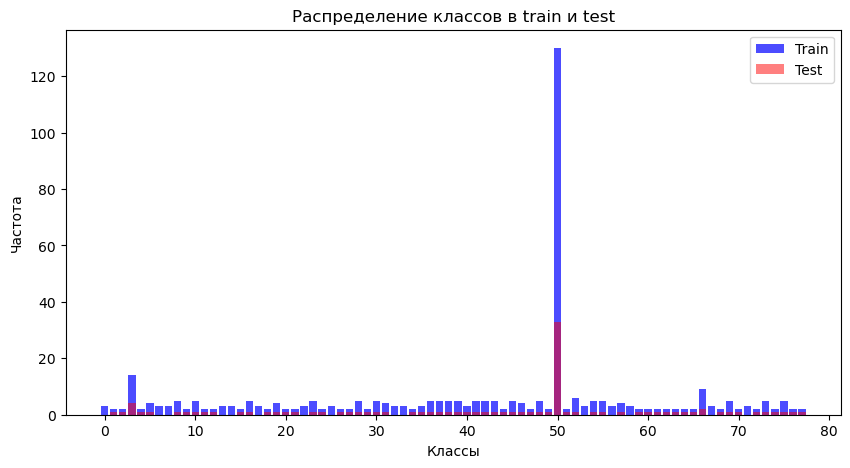

Accuracy: 0.7273
Precision: 0.8556


In [908]:
# Для precision посмотрим на распределение классов
plt.figure(figsize=(10,5))
plt.bar(*zip(*Counter(y_train).items()), color='blue', alpha=0.7, label="Train")
plt.bar(*zip(*Counter(y_test).items()), color='red', alpha=0.5, label="Test")
plt.xlabel("Классы")
plt.ylabel("Частота")
plt.title("Распределение классов в train и test")
plt.legend()
plt.show()

# доля правильных ответов в test
y_pred = rf_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc,4))

# точность модели
precision = precision_score(y_test, y_pred, average='weighted',  zero_division=1)  
print("Precision:", round(precision, 4))

## Итоги
#### Анализ модели
- Гистограмма показывает, что один класс:50 встречается гораздо чаще остальных - данные несбалансированные
- Доля правильных ответов (Accuracy) ≈ 68% неплохо, но модель может предсказывать самый частый класс (т.е. не показывает реальную производительность)
- Точность (Precision) ≈ 82% неплохо, однако модель не предсказывает редкие классы

#### Проблемы
- Переобучение на самый частый класс
- Редкие классы плохо предсказываются
- Балансировка классов (возможно расширение датасета)
